# Extrinsics Calibration

In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

import matplotlib as mpl

mpl.rc("figure", dpi=200)

from dt_computer_vision.camera import CameraModel

from dt_computer_vision.ground_projection.rendering import debug_image
from dt_computer_vision.ground_projection import GroundProjector

from dt_computer_vision.ground_projection.types import GroundPoint
from dt_computer_vision.camera import Pixel, NormalizedImagePoint

In [2]:
this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image0.jpg")
image_orig: np.ndarray = cv2.imread(image_fpath)

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]],
    # NOTE: this homography is computed in the 20-entrinsics-calibration jupyter notebook
    "H": [[-2.42749970e-02, 9.46389079e-02, 3.81909422e-01],
          [-4.55028567e-01, -1.17673909e-03, -1.87813039e-02],
          [-1.46006785e-01, 3.29784838e+00, 1]]
}

assert image_orig.shape == (480, 640, 3)

In [9]:
from copy import deepcopy

# define cropping
crop_x = int(image_orig.shape[1] * 0.5)
crop_y = int(image_orig.shape[0] * 0.5)

# create camera parameters
camera_params_orig = deepcopy(camera_properties)
camera_params_cropped = deepcopy(camera_properties)
camera_params_cropped["K"][0][2] -= crop_x
camera_params_cropped["K"][1][2] -= crop_y

# TODO: this should be using the rectified cx, cy instead
camera_params_cropped["P"][0][2] -= crop_x
camera_params_cropped["P"][1][2] -= crop_y

# crop image
image_cropped = image_orig[crop_y:, crop_x:, :]
assert image_cropped.shape == (image_orig.shape[0] - crop_y, image_orig.shape[1] - crop_x, image_orig.shape[2])

In [10]:
# create cameras
# - original
camera_orig = CameraModel(**camera_params_orig)
projector_orig = GroundProjector(camera_orig)

# - cropped
camera_cropped = CameraModel(**camera_params_cropped)
projector_cropped = GroundProjector(camera_cropped)

# check
assert np.allclose(camera_cropped.cx, camera_orig.cx - crop_x)
assert np.allclose(camera_cropped.cy, camera_orig.cy - crop_y)

In [11]:
# define fake segments
segments_orig = [
    (Pixel(200, 300), Pixel(400, 300)),
]
segments_cropped = [
    (Pixel(s[0].x - crop_x, s[0].y - crop_y), Pixel(s[1].x - crop_x, s[1].y - crop_y))
    for s in segments_orig
]

In [12]:
# project segments onto the ground plane
def project_and_render(cam, proj, segs):
    colored_segments = {}
    for segment in segs:
        # distorted pixels
        p0: Pixel = segment[0]
        p1: Pixel = segment[1]
        print(p0)
        # distorted pixels to rectified pixels
        p0_rect: Pixel = cam.rectifier.rectify_pixel(p0)
        p1_rect: Pixel = cam.rectifier.rectify_pixel(p1)
        print(p0_rect)
        # rectified pixel to normalized coordinates
        p0_norm: NormalizedImagePoint = cam.pixel2vector(p0_rect)
        p1_norm: NormalizedImagePoint = cam.pixel2vector(p1_rect)
        print(p0_norm)
        # project image point onto the ground plane
        p0_ground: GroundPoint = proj.vector2ground(p0_norm)
        p1_ground: GroundPoint = proj.vector2ground(p1_norm)
        print(p0_ground)
        # add grounded segment to output
        colored_segments[(255, 255, 255)] = [(p0_ground, p1_ground)]

    image_w_projected_segments = debug_image(colored_segments, (300, 300))
    image_w_projected_segments = cv2.cvtColor(image_w_projected_segments, cv2.COLOR_BGR2RGB)
    plt.imshow(image_w_projected_segments)

P(200, 300)
P(232.60003142514904, 287.00523537485003)
P(-0.29974072636424703, 0.1511291838331049)
P(0.26163753296453895, 0.07614712159263765)


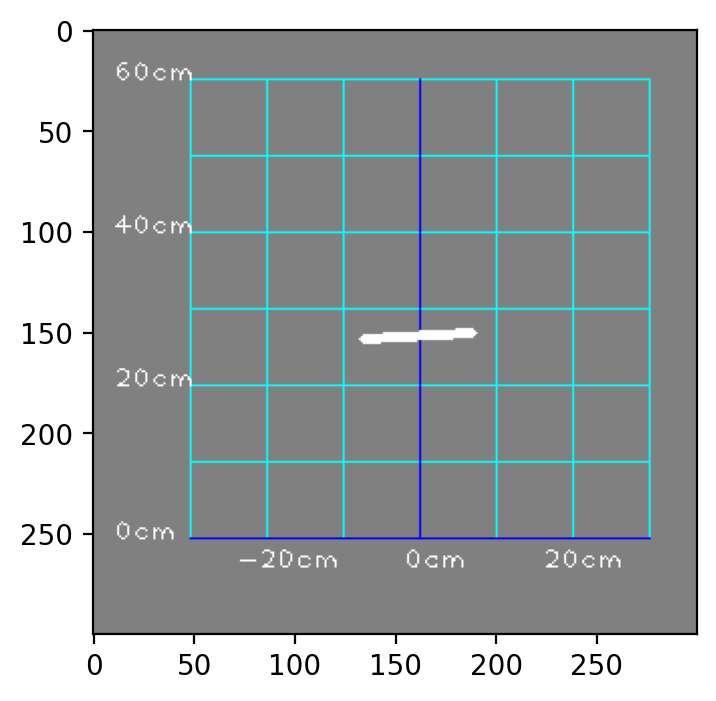

In [13]:
# project original
project_and_render(camera_orig, projector_orig, segments_orig)

P(-120, 60)
P(-87.39996857485094, 47.00523537485005)
P(-0.299740726364247, 0.15112918383310495)
P(0.2616375329645389, 0.07614712159263762)


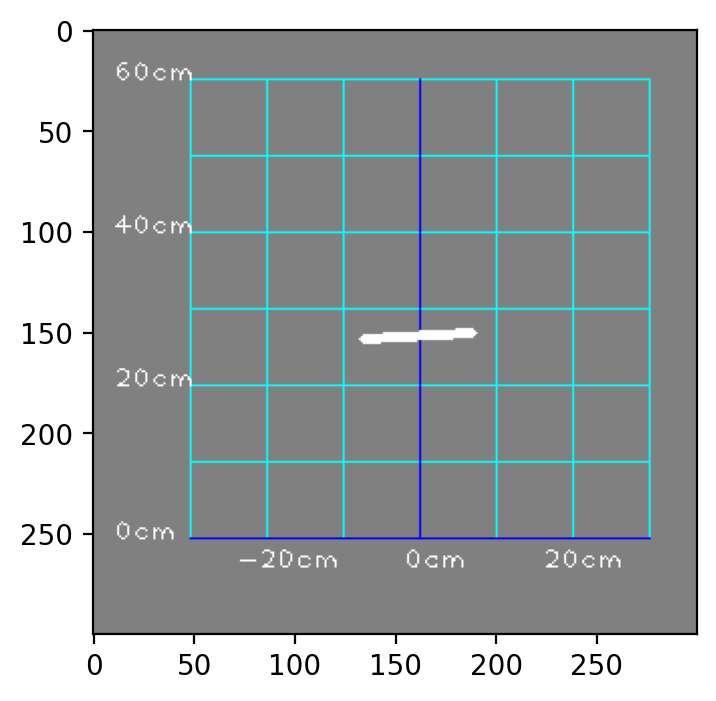

In [14]:
# project cropped
project_and_render(camera_cropped, projector_cropped, segments_cropped)